# Introduction

The context for these problems is that we are trying to understand causality. This causality is understood as a comparison between a set of subjects which have received a specific treatment and a set of sujects that has not received a treatment. The word treatment is commonly used from the medical field, but it can also indicate and specific effect on a group of which we want to measure an outcome. In social sciences, a treatment could be years of college education and the outcome we could be interested in measuring could be a potential the salary increase (see).

The gold standard is of course to carry out an experiment. We would then create a treatment and a control group (or more generally any number of groups) where subjects are randomly assigned to one of the groups. With a sufficiently large number of subjects, the randomness implies that the two groups will have sujects with similar starting characteristics and hence that the groups will not have any bias. This means that after treatment, the comparison of the groups will be fair and that we will in particular be able to measure a treatment effect.

Propensity score weighting is useful in the context of observational studies when experimental studies are not feasible or practical.

In this observational case, we need a methodology to select a control group (propensity score matching) or a methodology to remove the bias between treated and untreated subjects (propensity score weighting).


# Fundamental ideas

Let's take a look at the assumptions and how propensity weighting works.

## Conditional independence assumption (CIA)

The conditional independence assumption (CIA) also referred to as Strong Ignorability or Unconfoundedness, is is given by

$$ Y_{0i}, Y_{1i} \perp \!\!\!\perp T_i \mid \underline{X_i} $$

This is the assumption that the outcomes $Y_{0i}$ and $Y_{1i}$ are independent from the treatment, $T$ conditional on the covariates $X$. First it should be noted that $Y_{0i}$ and $Y_{1i}$ are not directly the outcome $Y$. Indeed, $Y$ can only ever take one of the two values, because each subject either receives the treatment or it doesn't. So one of these is always the counterfactual. 

It's easier to grasp what the CIA is saying with a small example. Let's imagine that we are interested in the mean weight of a population composed of females and males gorillas. Let's further suppose that there is a treatment group and a control group (although in this example we do not apply a treatment). The treatment group is composed of 25% males and 75% females, whereas the control group is the opposite. In our example the mean weight for males is  374 lbs whereas the mean weight for females is 158 lbs (data for Western Lowland gorillas sourced [here](https://seaworld.org/animals/all-about/gorilla/characteristics/). Clearly the mean weights $Y_{i0}$ and $Y_{1i}$ are not independent from the treatment assigment $T$. But they are independent conditional on gender covariate $X$ if the female weight and the male weight has the same mean in both groups, because there is no information we can obtain about the treatment if one considers separately the male and female weights.

But, as we will see later, if we omit a conditional variable we are at risk again of losing the independence. This would be the case for instance if the control group was not anymore formed only by Western Lowland gorillas, but instead contained a proportion of Eastern Lowland gorillas which have mean weights of 484 lbs and 176 lbs for males and females respectively. We could of course, if we knew that we had different types of gorillas in our sample, extend the covariate vector $\underline{X}$ to contain both weight and gorilla type.


## Why the CIA matters

The CIA matters because if the assignment to a treatment group is not independent given the covariates, there is no way to determine if a change in the outcome in the treatment group is the effect of the treatment or if it is due to a conditional dependence. In the gorillas examples, if for instance the treatment consisted of a different diet, we would not know if the difference in weight observed between the treatment and control groups would be due to the diet or to the (unknown) presence of Lowland gorillas in the treatment group.

We can see this better mathematically:

$$ $$



## Propensity theorem

We define the propensity $\pi(\underline{X})$ as the probability based on the information in $\underline{X}$ of belonging to the treatment group. We will see later that this probability can be estimated for example via logistic or 
gradient boosted trees regression.

Then under the CIA the following holds

$$ Y_{0i}, Y_{1i} \perp \!\!\!\perp T_i \mid \pi(\underline{X_i}) $$

that is, the propensity is also conditionally independent.

Furthermore, the propensity $\pi(\underline{X})$ can be used to estimate the average treatment effect in the same way as the vector as covariates $\underline{X}$.  

The reason this theorem is important is that the propensity $\pi(\underline{X})$ is a scalar and makes the computation of the average treatment effect tractable.

For some intuition behind the equivalence, what we need to show is that:

\begin{align}
P\left(D_i=1 \mid Y_{ij}, P(X_i)\right) &=  \mathbb{E}\left[D_i \mid Y_{ij}, P(X_i)\right] \\
&=\mathbb{E}\left[\mathbb{E}\left[D_i \mid Y_{ij}, P(X_i), X_i\right] \mid Y_{ij}, P(X_i) \right] \\
&=\mathbb{E}\left[\mathbb{E}\left[D_i \mid X_i\right] \mid Y_{ij}, P(X_i) \right] \quad\quad \text{(using CIA)} \\
&=\mathbb{E}\left[P(X_i) \mid Y_{ij}, P(X_i) \right] \\
&=P(X_i)
\end{align}


# Trying out some stuff

## A simple univariate case

From ChatGPT:

**Background**: A local hospital is trying to understand factors that might influence the recovery speed (measured as the number of days spent in the hospital) after undergoing a specific surgery. The surgical procedure is common and is performed on both patients who are smokers and those who are non-smokers. Moreover, patients have the option of undergoing either a traditional surgical method or a newer, minimally invasive method.

**Research Question**: Does smoking status and the type of surgical method influence the recovery time of patients?

**Binary Variables**:

- Smoking Status:

    - 0: Non-Smoker
    - 1: Smoker

- Surgical Method:

    - 0: Traditional Surgery    
    - 1: Minimally Invasive Surgery (new surgery)

**Outcome Variable**: Recovery time: A continuous variable representing the number of days a patient spends in the hospital post-surgery.

**Data Collection**:
The hospital collects data over a year from patients who underwent the procedure, noting down their smoking status, the type of surgical method, and their recovery time.

**Regression Story**:
- Smokers who undergo traditional surgery have a significantly longer recovery time compared to non-smokers who undergo the same traditional method. This could be due to the overall decreased lung efficiency and increased risk of post-surgical complications in smokers.

- However, when opting for the minimally invasive method, the difference in recovery time between smokers and non-smokers narrows down. The minimally invasive procedure, being less taxing on the body, might be reducing the impact of smoking on recovery.

- On its own, the minimally invasive surgery results in faster recovery times compared to the traditional method for both smokers and non-smokers. Yet, the advantage of the minimally invasive method seems even more pronounced for smokers, making it a favorable option for this group.

**Conclusion**:
The hospital might consider recommending the minimally invasive surgical method, especially for smokers, to ensure faster recovery times. Additionally, pre-surgical counseling for smokers about the risks and benefits associated with each method could be beneficial.

In [1]:
library(data.table)
library(PSweight)
library(ggplot2)

In [2]:
N <- 200      ## nb of patients in each group
p_s <- 0.75   ## pct smokers in treatment group

In [3]:
## 75% percent smoker in the test group, 25% in the control group:
ex1 <- data.table(test=rep(c(TRUE, FALSE), each=N), 
                  smoker=c(as.logical(rbinom(N, 1, p_s)), as.logical(rbinom(N, 1, 1 - p_s))))
print(ex1)

      test smoker
  1:  TRUE   TRUE
  2:  TRUE   TRUE
  3:  TRUE   TRUE
  4:  TRUE   TRUE
  5:  TRUE   TRUE
 ---             
396: FALSE   TRUE
397: FALSE   TRUE
398: FALSE  FALSE
399: FALSE   TRUE
400: FALSE   TRUE


In [4]:
# smokers have mean 60 days recovery, non-smokers 30 days
ex1[smoker==TRUE, recovery := rnorm(sum(ex1$smoker), 60, 6)]
ex1[smoker==FALSE, recovery := rnorm(sum(!ex1$smoker), 30, 3)]
print(ex1, topn=10)

      test smoker recovery
  1:  TRUE   TRUE 63.06242
  2:  TRUE   TRUE 68.18916
  3:  TRUE   TRUE 58.01755
  4:  TRUE   TRUE 53.95745
  5:  TRUE   TRUE 56.49341
  6:  TRUE   TRUE 53.02463
  7:  TRUE   TRUE 72.37134
  8:  TRUE   TRUE 59.56458
  9:  TRUE   TRUE 59.36989
 10:  TRUE   TRUE 66.38388
 ---                      
391: FALSE  FALSE 28.65694
392: FALSE  FALSE 28.81966
393: FALSE  FALSE 31.95770
394: FALSE  FALSE 27.46349
395: FALSE  FALSE 31.36934
396: FALSE   TRUE 59.27232
397: FALSE   TRUE 60.75216
398: FALSE  FALSE 31.32790
399: FALSE   TRUE 68.95851
400: FALSE   TRUE 61.58575


In [5]:
logistic_model <- glm("test ~ smoker", family=binomial, data=ex1)
summary(logistic_model)


Call:
glm(formula = "test ~ smoker", family = binomial, data = ex1)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.67880  -0.63840   0.05508   0.74856   1.83896  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.4871     0.1927  -7.715 1.21e-14 ***
smokerTRUE    2.6161     0.2483  10.536  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 554.52  on 399  degrees of freedom
Residual deviance: 416.87  on 398  degrees of freedom
AIC: 420.87

Number of Fisher Scoring iterations: 4


In [6]:
## get the probabilities of belonging to the treatment group, the propensity:
ex1[, propensity := predict(logistic_model, ex1[, .(smoker)], type="response")]
print(ex1, topn=10)

      test smoker recovery propensity
  1:  TRUE   TRUE 63.06242  0.7556561
  2:  TRUE   TRUE 68.18916  0.7556561
  3:  TRUE   TRUE 58.01755  0.7556561
  4:  TRUE   TRUE 53.95745  0.7556561
  5:  TRUE   TRUE 56.49341  0.7556561
  6:  TRUE   TRUE 53.02463  0.7556561
  7:  TRUE   TRUE 72.37134  0.7556561
  8:  TRUE   TRUE 59.56458  0.7556561
  9:  TRUE   TRUE 59.36989  0.7556561
 10:  TRUE   TRUE 66.38388  0.7556561
 ---                                 
391: FALSE  FALSE 28.65694  0.1843575
392: FALSE  FALSE 28.81966  0.1843575
393: FALSE  FALSE 31.95770  0.1843575
394: FALSE  FALSE 27.46349  0.1843575
395: FALSE  FALSE 31.36934  0.1843575
396: FALSE   TRUE 59.27232  0.7556561
397: FALSE   TRUE 60.75216  0.7556561
398: FALSE  FALSE 31.32790  0.1843575
399: FALSE   TRUE 68.95851  0.7556561
400: FALSE   TRUE 61.58575  0.7556561


In [7]:
## now calculate the weights:
ex1[test==TRUE, weight := 1 / propensity]
ex1[test==FALSE, weight := 1 / (1 - propensity)]
print(ex1, topn=10)

      test smoker recovery propensity   weight
  1:  TRUE   TRUE 63.06242  0.7556561 1.323353
  2:  TRUE   TRUE 68.18916  0.7556561 1.323353
  3:  TRUE   TRUE 58.01755  0.7556561 1.323353
  4:  TRUE   TRUE 53.95745  0.7556561 1.323353
  5:  TRUE   TRUE 56.49341  0.7556561 1.323353
  6:  TRUE   TRUE 53.02463  0.7556561 1.323353
  7:  TRUE   TRUE 72.37134  0.7556561 1.323353
  8:  TRUE   TRUE 59.56458  0.7556561 1.323353
  9:  TRUE   TRUE 59.36989  0.7556561 1.323353
 10:  TRUE   TRUE 66.38388  0.7556561 1.323353
 ---                                          
391: FALSE  FALSE 28.65694  0.1843575 1.226027
392: FALSE  FALSE 28.81966  0.1843575 1.226027
393: FALSE  FALSE 31.95770  0.1843575 1.226027
394: FALSE  FALSE 27.46349  0.1843575 1.226027
395: FALSE  FALSE 31.36934  0.1843575 1.226027
396: FALSE   TRUE 59.27232  0.7556561 4.092593
397: FALSE   TRUE 60.75216  0.7556561 4.092593
398: FALSE  FALSE 31.32790  0.1843575 1.226027
399: FALSE   TRUE 68.95851  0.7556561 4.092593
400: FALSE   

In [8]:
print(sum(ex1[test==TRUE ]$smoker)    / nrow(ex1[test==TRUE]))
print(sum(ex1[test==FALSE]$smoker)    / nrow(ex1[test==FALSE]))
print(sum(ex1[test  & smoker]$weight) / sum(ex1[test==TRUE]$weight))
print(sum(ex1[!test & smoker]$weight) / sum(ex1[test==FALSE]$weight))

[1] 0.835
[1] 0.27
[1] 0.5525
[1] 0.5525


Without the propensity weights, we see that the difference between test and control group is significant:

In [9]:
summary(aov(recovery ~ test, data=ex1))

             Df Sum Sq Mean Sq F value Pr(>F)    
test          1  29495   29495   167.6 <2e-16 ***
Residuals   398  70042     176                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

But when we use the weights, we see that this difference is not significant, because it is entirely explained by the higher percentage of smokers in the test group, which is "matched" out when we use the weights:

In [10]:
summary(aov(recovery ~ test, data=ex1, weights=ex1$weight))

             Df Sum Sq Mean Sq F value Pr(>F)
test          1     15    15.4   0.031   0.86
Residuals   398 195662   491.6               

### Checking with PSweight

In [11]:
ipw <- PSweight(test ~ smoker, data=ex1, yname="recovery", weight="IPW")
print(summary(ipw))
ipw


Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error      lwr    upr Pr(>|z|)
Contrast 1  0.27714   0.55019 -0.80121 1.3555   0.6145


Original group value:  FALSE, TRUE 

Point estimate: 
46.3485, 46.6256 

In [12]:
summary(ipw)


Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error      lwr    upr Pr(>|z|)
Contrast 1  0.27714   0.55019 -0.80121 1.3555   0.6145

## Problems

### Missing propensity variable

### Small divisors

We introduce a new covariate `new_surgery`. In the test group, we assign all smokers to new_surgery and all non-smokers to non-new_surgerys; in the control group, we assign the new_surgerys randomly to the whole population with the same probability as the probability of being smoker in the control group (0.75).

In [13]:
ex2 <- copy(ex1)
ex2[test==TRUE, new_surgery := smoker]
#ex2[test & smoker, new_surgery := rbinom(nrow(ex2[test & smoker]), 1, 0.9)]
#ex2[test & !smoker, new_surgery := rbinom(nrow(ex2[test & !smoker]), 1, 0.1)]
ex2[test==FALSE, new_surgery := rbinom(nrow(ex2[test==FALSE]), 1, p_s)]

In [14]:
## percent smoker new_surgerys:
nrow(ex2[test & smoker & new_surgery])/nrow(ex2[test & smoker])

[1] 1

In [15]:
## percent male new_surgerys:
nrow(ex2[test & !smoker & new_surgery])/nrow(ex2[test & !smoker])

[1] 0

In [16]:
logistic_model <- glm("test ~ smoker + new_surgery", family=binomial, data=ex2)
summary(logistic_model)


Call:
glm(formula = "test ~ smoker + new_surgery", family = binomial, 
    data = ex2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1666  -0.5623   0.1421   0.7636   1.5948  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.9427     0.2436  -3.870 0.000109 ***
smokerTRUE        3.1892     0.3381   9.432  < 2e-16 ***
new_surgeryTRUE  -1.1632     0.3771  -3.085 0.002038 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 554.52  on 399  degrees of freedom
Residual deviance: 406.36  on 397  degrees of freedom
AIC: 412.36

Number of Fisher Scoring iterations: 4


In [17]:
ex2[, propensity := predict(logistic_model, ex2, type="response")]
ex2[test==TRUE, weight := 1 / propensity]
ex2[test==FALSE, weight := 1 / (1 - propensity)]
print(ex2, topn=10)

      test smoker recovery propensity    weight new_surgery
  1:  TRUE   TRUE 63.06242  0.7471187  1.338475        TRUE
  2:  TRUE   TRUE 68.18916  0.7471187  1.338475        TRUE
  3:  TRUE   TRUE 58.01755  0.7471187  1.338475        TRUE
  4:  TRUE   TRUE 53.95745  0.7471187  1.338475        TRUE
  5:  TRUE   TRUE 56.49341  0.7471187  1.338475        TRUE
  6:  TRUE   TRUE 53.02463  0.7471187  1.338475        TRUE
  7:  TRUE   TRUE 72.37134  0.7471187  1.338475        TRUE
  8:  TRUE   TRUE 59.56458  0.7471187  1.338475        TRUE
  9:  TRUE   TRUE 59.36989  0.7471187  1.338475        TRUE
 10:  TRUE   TRUE 66.38388  0.7471187  1.338475        TRUE
 ---                                                       
391: FALSE  FALSE 28.65694  0.1085219  1.121733        TRUE
392: FALSE  FALSE 28.81966  0.1085219  1.121733        TRUE
393: FALSE  FALSE 31.95770  0.1085219  1.121733        TRUE
394: FALSE  FALSE 27.46349  0.2803520  1.389568       FALSE
395: FALSE  FALSE 31.36934  0.1085219  1

In [18]:
summary(aov(recovery ~ test, data=ex2))

             Df Sum Sq Mean Sq F value Pr(>F)    
test          1  29495   29495   167.6 <2e-16 ***
Residuals   398  70042     176                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [19]:
summary(aov(recovery ~ test, data=ex2, weights=ex2$weight))

             Df Sum Sq Mean Sq F value Pr(>F)
test          1    530   529.6   1.136  0.287
Residuals   398 185619   466.4               

In [20]:
print(sum(ex2[test==TRUE]$smoker)/nrow(ex2[test==TRUE]))
print(sum(ex2[test==FALSE]$smoker)/nrow(ex2[test==FALSE]))
print(sum(ex2[test &  smoker]$weight)/sum(ex2[test==TRUE]$weight))
print(sum(ex2[!test & smoker]$weight)/sum(ex2[test==FALSE]$weight))

[1] 0.835
[1] 0.27
[1] 0.6550491
[1] 0.6234392


In [21]:
print(sum(ex2[test==TRUE]$new_surgery)/nrow(ex2[test==TRUE]))
print(sum(ex2[test==FALSE]$new_surgery)/nrow(ex2[test==FALSE]))
print(sum(ex2[test &  new_surgery]$weight)/sum(ex2[test==TRUE]$weight))
print(sum(ex2[!test & new_surgery]$weight)/sum(ex2[test==FALSE]$weight))

[1] 0.835
[1] 0.71
[1] 0.6550491
[1] 0.5950334


Now let's imagine new_surgery has an effect, if you're a new_surgery, you're 15 recovery lighter:

In [22]:
ex2[new_surgery==TRUE, recovery := recovery + 50]

In [23]:
summary(aov(recovery ~ test, data=ex2))

             Df Sum Sq Mean Sq F value   Pr(>F)    
test          1  54870   54870   64.38 1.16e-14 ***
Residuals   398 339207     852                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

We find then with these weights that the test group is significantly different from the control group, which we know by design of this simulation is not true:

In [24]:
summary(aov(recovery ~ test, data=ex2, weights=ex2$weight))

             Df Sum Sq Mean Sq F value Pr(>F)
test          1   4246    4246   1.892   0.17
Residuals   398 893078    2244               

### Running PSweight

In [25]:
ipw <- PSweight(test ~ smoker + new_surgery, data=ex2, yname="recovery", weight="IPW")
print(ipw)
summary(ipw)

Original group value:  FALSE, TRUE 

Point estimate: 
77.8015, 82.4408 



Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error     lwr   upr Pr(>|z|)
Contrast 1   4.6393    3.4292 -2.0819 11.36   0.1761

In [26]:
ipw_ss <- SumStat(test ~ smoker + new_surgery, data=ex2, weight="IPW")
summary(ipw_ss)

unweighted result
                Mean FALSE Mean TRUE   SMD
smokerTRUE            0.27     0.835 1.377
new_surgeryTRUE       0.71     0.835 0.301

IPW result
                Mean FALSE Mean TRUE   SMD
smokerTRUE           0.623     0.655 0.077
new_surgeryTRUE      0.595     0.655 0.144


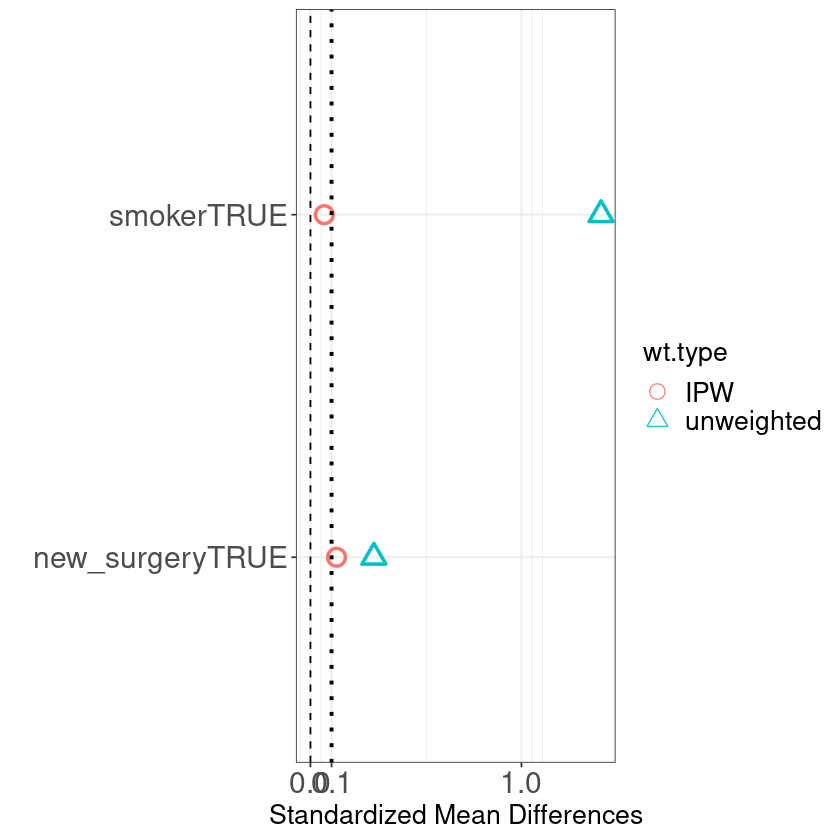

In [27]:
plot(ipw_ss)

In [28]:
aipw <- PSweight(test ~ smoker + new_surgery, data=ex2, yname="recovery", weight="IPW", 
                augmentation = TRUE, out.formula = recovery ~ smoker + new_surgery)
summary(ipw)

Warning message in predict.lm(fitglm, type = "response", dataout):
“prediction from a rank-deficient fit may be misleading”



Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error     lwr   upr Pr(>|z|)
Contrast 1   4.6393    3.4292 -2.0819 11.36   0.1761

# AIPW

Let's examine the Augmented Inverse Propensity Weighting. We start by simulating a simple treatment/control group with a couple of covariates.

$$Y_{i} \sim X_{i}\beta + W_{i}\tau + \epsilon$$

To add some realism, we'll have our treatment have a different range of X and fix $\beta$ and $\tau$.

$$X_{treat} \sim Normal(\mu=4, \sigma=1)$$
$$X_{cntl} \sim Normal(\mu=6, \sigma=1)$$
$$\beta = 2$$
$$\tau = 1$$
$$\epsilon \sim Normal(\mu=0.2, \sigma=1)$$

In [29]:
sz <- 250
beta1 <- 2
tau <- 1
mu_epsilon <- 0.1
dt <- data.table(x1=c(rnorm(sz, 4, 1), rnorm(sz, 6, 1)), 
                 W=c(rep(1, sz), rep(0, sz)),
                 epsilon=rnorm(sz*2, mu_epsilon, 1))
dt[, y := x1 * beta1 + W * tau + epsilon]
print(summary(dt[W==1]))
print(summary(dt[W==0]))

       x1                 W        epsilon               y          
 Min.   :-0.03698   Min.   :1   Min.   :-3.48520   Min.   : 0.4376  
 1st Qu.: 3.38471   1st Qu.:1   1st Qu.:-0.72864   1st Qu.: 7.7401  
 Median : 4.01342   Median :1   Median :-0.02724   Median : 9.0459  
 Mean   : 4.03029   Mean   :1   Mean   : 0.04855   Mean   : 9.1091  
 3rd Qu.: 4.71283   3rd Qu.:1   3rd Qu.: 0.79827   3rd Qu.:10.6091  
 Max.   : 6.82759   Max.   :1   Max.   : 3.85429   Max.   :16.1020  
       x1              W        epsilon              y         
 Min.   :3.490   Min.   :0   Min.   :-2.4758   Min.   : 6.415  
 1st Qu.:5.355   1st Qu.:0   1st Qu.:-0.4860   1st Qu.:10.771  
 Median :6.032   Median :0   Median : 0.1646   Median :12.359  
 Mean   :6.032   Mean   :0   Mean   : 0.1672   Mean   :12.232  
 3rd Qu.:6.682   3rd Qu.:0   3rd Qu.: 0.8656   3rd Qu.:13.676  
 Max.   :8.893   Max.   :0   Max.   : 2.3247   Max.   :18.288  


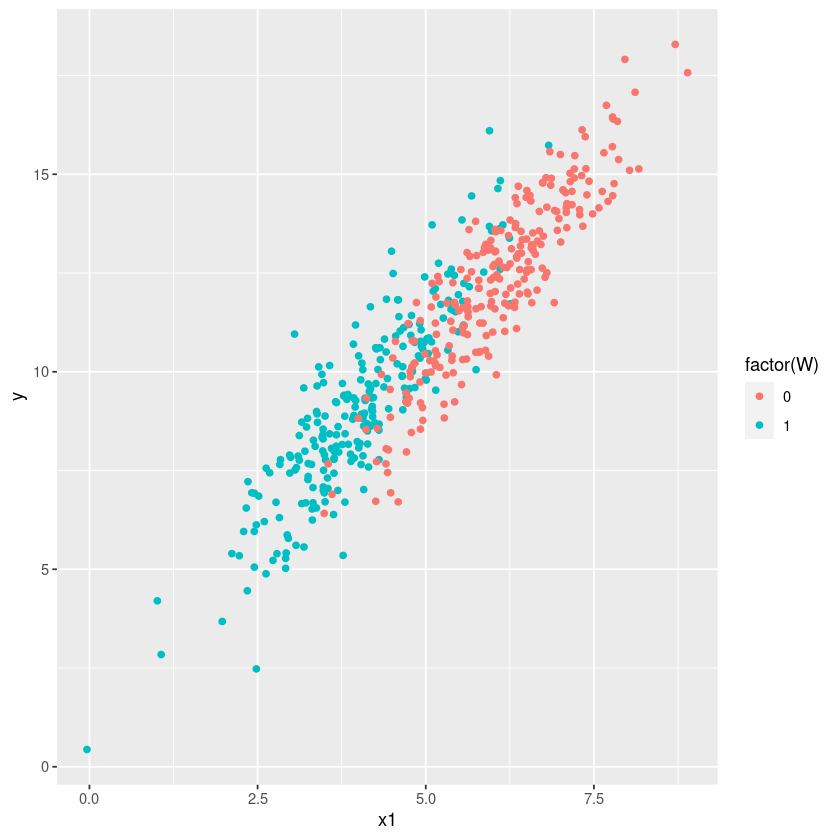

In [30]:
ggplot(dt, aes(x1, y, color=factor(W))) +
    geom_point()

## IPW

First we use a logistic regression to figure out the propensity score *e(i)*

In [31]:
propensity_model <- glm(W ~ x1, data=dt, family=binomial)
summary(propensity_model)


Call:
glm(formula = W ~ x1, family = binomial, data = dt)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.47826  -0.50966  -0.01093   0.50283   2.67179  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   9.8890     0.8572   11.54   <2e-16 ***
x1           -1.9670     0.1686  -11.67   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 693.15  on 499  degrees of freedom
Residual deviance: 357.44  on 498  degrees of freedom
AIC: 361.44

Number of Fisher Scoring iterations: 6


In [32]:
dt[, e := predict(propensity_model, data=dt, type="response")]
print(dt)

           x1 W     epsilon         y          e
  1: 5.376376 1 -0.16994889 11.582803 0.33488426
  2: 4.659048 1 -1.28155370  9.036543 0.67365895
  3: 3.937517 1 -1.05665188  7.818381 0.89510745
  4: 4.304643 1 -1.83448416  7.774801 0.80563358
  5: 4.834769 1  0.07472833 10.744267 0.59366668
 ---                                            
496: 7.317620 0  0.33106009 14.966301 0.01093779
497: 6.037196 0  1.47111847 13.545511 0.12068215
498: 5.372362 0  0.53278655 11.277511 0.33664489
499: 6.174783 0 -0.61498169 11.734585 0.09478040
500: 6.049840 0 -2.17497558  9.924705 0.11806775


And now we can estimate the propensity weighted means and see what $\tau$ we get:

In [33]:
mu1 <- sum(dt$W * dt$y / dt$e) / sum(dt$W / dt$e)
mu0 <- sum((1-dt$W) * dt$y / (1-dt$e)) / sum((1 - dt$W) / (1 - dt$e))
cat(paste("mu1:", mu1, "\n"))
cat(paste("mu0:", mu0, "\n"))
ATE_prop <- mu1 - mu0
print(ATE_prop)

mu1: 10.8416659423644 
mu0: 10.7628082430946 
[1] 0.0788577


So it's fair to say we've done a reasonable job of estimating tau.

## Regression

Now let's look at a second way of approching the problem. Here we estimate directly $\mu_{0}$
and $\mu_{1}$ from the treatment and control groups, conditional on X.

Note the regression is conducted separately on the two groups. It is not:

$$Y \sim X\beta + W\tau + \epsilon$$

but instead:

$$Y_{1} \sim X_{1}\beta_{1} + \epsilon$$
$$Y_{0} \sim X_{0}\beta_{0} + \epsilon$$

"We emphasize that, throughout our analysis, we defined the target estimand τ = E [∆i] before making any modeling assumptions. Linear modeling was only used as a tool to estimate τ , but did not inform the scientific question we tried to answer. In particular, we did not try to estimate τ by direct regression modeling $Y_{i} \sim X_{i}\beta + W_{i}\tau + \epsilon_{i}$, while claiming that the coefficient on τ is a causal effect. This approach has the vice of tying our scientific question to our regression modeling strategy: τ appears to just have become a coefficient in our linear model, not a fact of nature that’s conceptually prior to modeling decisions." (https://web.stanford.edu/~swager/stats361.pdf, page 8).

In [34]:
model_mu1 <- lm(y ~ x1, data=dt[W==1])
summary(model_mu1)


Call:
lm(formula = y ~ x1, data = dt[W == 1])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4636 -0.7723 -0.0817  0.7178  3.8501 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.86607    0.28271   3.064  0.00243 ** 
x1           2.04528    0.06803  30.066  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.09 on 248 degrees of freedom
Multiple R-squared:  0.7847,	Adjusted R-squared:  0.7838 
F-statistic: 903.9 on 1 and 248 DF,  p-value: < 2.2e-16


In [35]:
model_mu0 <- lm(y ~ x1, data=dt[W==0])
summary(model_mu0)


Call:
lm(formula = y ~ x1, data = dt[W == 0])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.63419 -0.65226 -0.00326  0.68334  2.15929 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.13030    0.37498   0.347    0.729    
x1           2.00611    0.06134  32.707   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9635 on 248 degrees of freedom
Multiple R-squared:  0.8118,	Adjusted R-squared:  0.811 
F-statistic:  1070 on 1 and 248 DF,  p-value: < 2.2e-16


Now we've got our models for $\mu_{1}$, $\mu_{0}$, we evaluate them conditional on all X:

In [36]:
ATE_reg <- 1/nrow(dt) * sum(predict(model_mu1, dt) - predict(model_mu0, dt))
ATE_reg

[1] 0.9328288

## IPW + regression = AIPW

We now use both the IPW and the regression to get the Augmented IPW; for this, the idea is to calculate mu0 and mu1, and then to use the IPW on the residuals of the regression instead of directly on the Y.

In [37]:
ATE_aipw <- 1/nrow(dt) * sum(predict(model_mu1, dt) - predict(model_mu0, dt) + 
                             dt$W * (dt$y - predict(model_mu1, dt)) / dt$e -
                             (1-dt$W) * (dt$y - predict(model_mu0, dt)) / (1-dt$e))
ATE_aipw

[1] 1.06955

## Let's get some confirmation using the package PSweight

In [50]:
ipw <- PSweight(W ~ x1, data=dt, yname="y", weight="IPW")
ipw$muhat["1"] - ipw$muhat["0"]
ipw
summary(ipw)

1 
0.0788577

Original group value:  0, 1 

Point estimate: 
10.7628, 10.8417 


Closed-form inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

            Estimate Std.Error       lwr     upr Pr(>|z|)
Contrast 1  0.078858  0.339807 -0.587153 0.74487   0.8165

In [51]:
aug = PSweight(W ~ x1, data=dt, yname="y", weight="IPW", augmentation = TRUE, out.formula = y ~ x1)
aug$muhat["1"] - aug$muhat["0"]
aug
summary(aug)

1 
1.081717

Original group value:  0, 1 

Point estimate: 
10.1615, 11.2432 


Closed-form inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

           Estimate Std.Error     lwr    upr  Pr(>|z|)    
Contrast 1  1.08172   0.15231 0.78320 1.3802 1.228e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# Weight distributions

## Treatment and control share the same distribution

In [40]:
N <- 1000
tc_same <- data.table(x=rnorm(N*2, 0, 1), treatment=c(rep(FALSE, N), rep(TRUE, N)))
head(tc_same)

x,treatment
<dbl>,<lgl>
-0.09229613,FALSE
-0.41156662,FALSE
0.28969536,FALSE
-0.37152085,FALSE
1.05408623,FALSE
0.23795018,FALSE


In [41]:
model_tc_same <- SumStat(treatment ~ x, data=tc_same)

In [42]:
mirror_plot <- function(data, model) {
    data <- copy(data)
    data[, weight := model$propensity[, 2]]
    p <- ggplot() +
      # Top
      geom_density(data=data[treatment==TRUE], aes(x = weight, y = after_stat(density)), binwidth=0.05, fill="#69b3a2" ) +
      geom_label( aes(x=1, y=1, label="treatment"), color="#69b3a2") +
      # Bottom
      geom_density(data=data[treatment==FALSE], aes(x = weight, y = after_stat(-density)), binwidth=0.05, fill= "#404080") +
      geom_label( aes(x=1, y=-1, label="control"), color="#404080") +
      xlim(x=c(0,1)) +
      xlab("weight")
    p
}

Warning message in geom_density(data = data[treatment == TRUE], aes(x = weight, :
“Ignoring unknown parameters: `binwidth`”
Warning message in geom_density(data = data[treatment == FALSE], aes(x = weight, :
“Ignoring unknown parameters: `binwidth`”


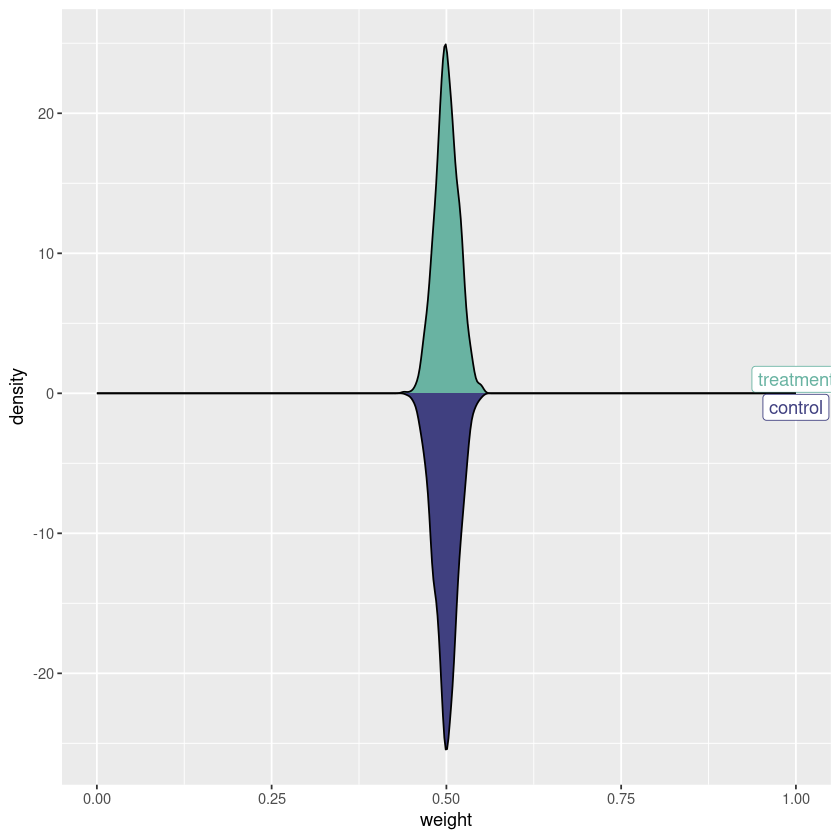

In [43]:
mirror_plot(tc_same, model_tc_same)

## Distributions differ only in mean

Warning message in geom_density(data = data[treatment == TRUE], aes(x = weight, :
“Ignoring unknown parameters: `binwidth`”
Warning message in geom_density(data = data[treatment == FALSE], aes(x = weight, :
“Ignoring unknown parameters: `binwidth`”


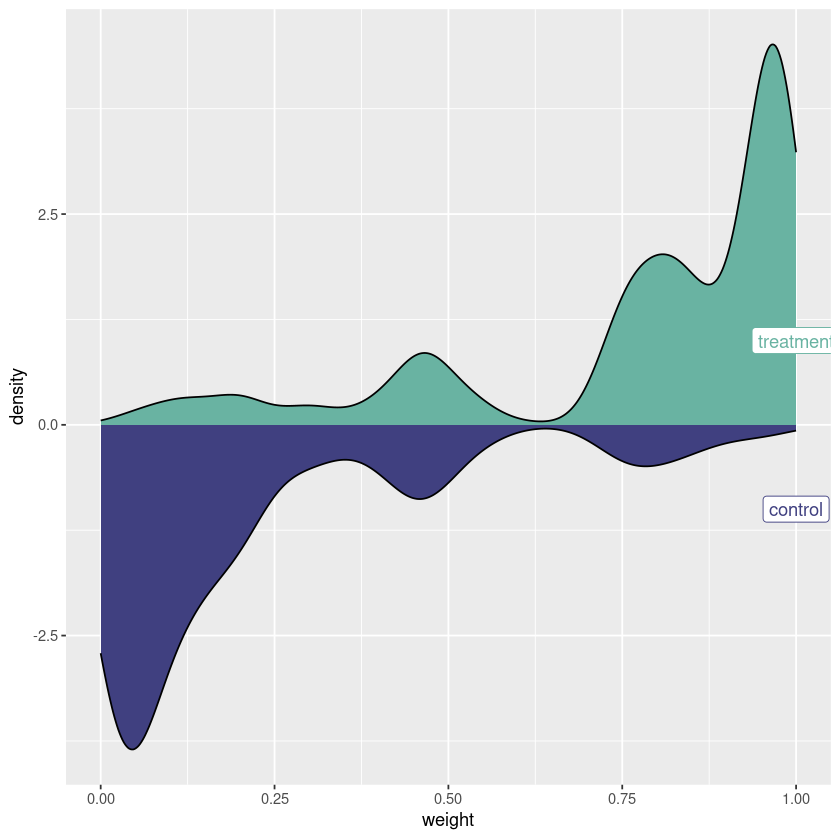

In [44]:
tc_diff_means <- data.table(x=c(rnorm(N, 0, 1), rnorm(N, 2, 1)),
                                treatment=c(rep(FALSE, N), rep(TRUE, N)))
model_diff_means <- SumStat(treatment ~ x, data=tc_diff_means, method="gbm")
mirror_plot(tc_diff_means, model_diff_means)

## Distributions differ only in variance

Warning message in geom_density(data = data[treatment == TRUE], aes(x = weight, :
“Ignoring unknown parameters: `binwidth`”
Warning message in geom_density(data = data[treatment == FALSE], aes(x = weight, :
“Ignoring unknown parameters: `binwidth`”


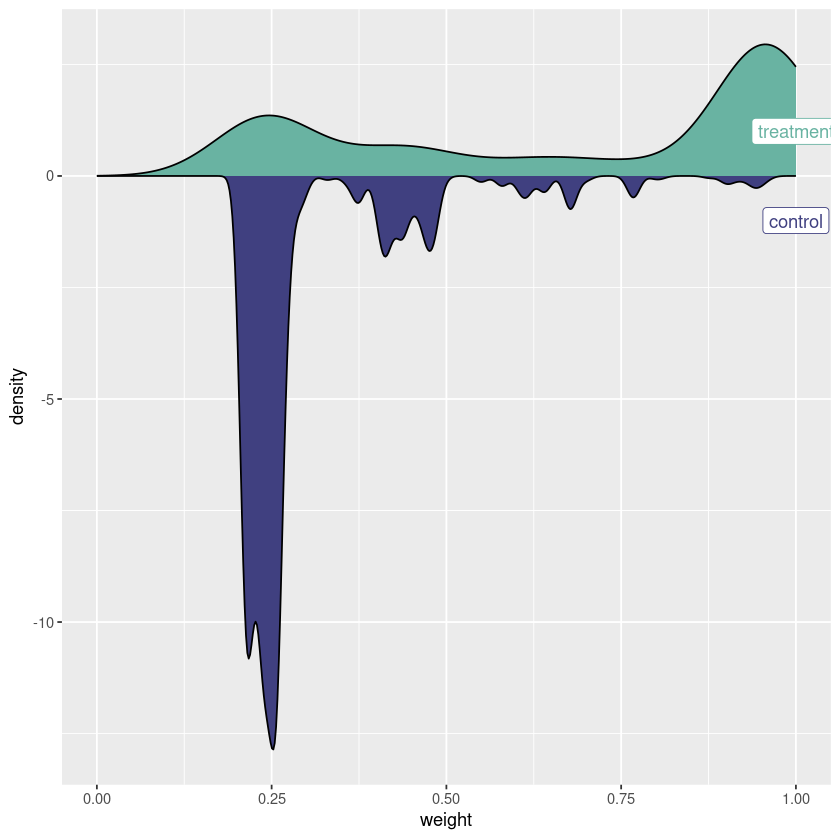

In [45]:
tc_diff_vars <- data.table(x=c(rnorm(N, 0, 1), rnorm(N, 0, 4)),
                                treatment=c(rep(FALSE, N), rep(TRUE, N)))
model_diff_vars <- SumStat(treatment ~ x, data=tc_diff_vars, method="gbm")
mirror_plot(tc_diff_vars, model_diff_vars)

## inflation at one end
Here we try something that variance itself can't give us. We artificially inflate with a large number of values that are most exclusive to the control group than the treatment group.

Warning message in geom_density(data = data[treatment == TRUE], aes(x = weight, :
“Ignoring unknown parameters: `binwidth`”
Warning message in geom_density(data = data[treatment == FALSE], aes(x = weight, :
“Ignoring unknown parameters: `binwidth`”


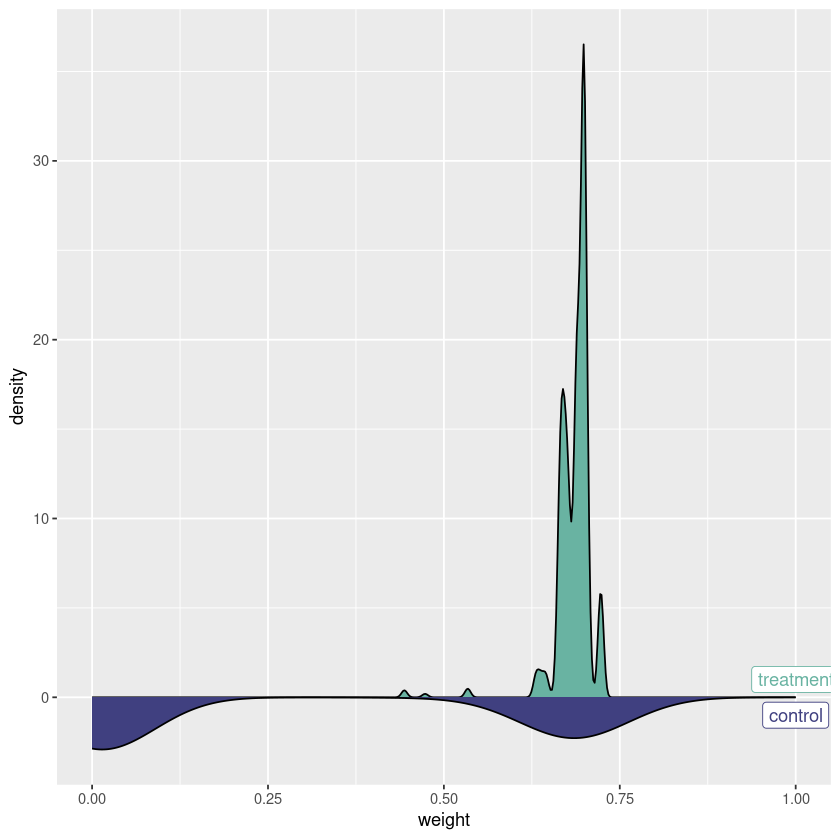

In [46]:
tc_inflation <- data.table(x=c(rpois(N, 20), rpois(N, 20)),
                                treatment=c(rep(FALSE, N), rep(TRUE, N)))
tc_inflation[0:(N/20), x := 0]
tc_inflation[N:(N - N/2), x := 0]
model_inflation <- SumStat(treatment ~ x, data=tc_inflation, method="gbm")
mirror_plot(tc_inflation, model_inflation)

In [47]:
tc_inflation[, weight := model_inflation$propensity[, 2]]

hist(tc_inflation[treatment==FALSE]$weight, breaks=20, plot=FALSE, freq=FALSE)

Warning message in hist.default(tc_inflation[treatment == FALSE]$weight, breaks = 20, :
“argument ‘freq’ is not made use of”


$breaks
 [1] 0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70
[16] 0.75

$counts
 [1] 551   0   0   0   0   0   0   0   1   2   3   0  19 381  43

$density
 [1] 11.02  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.02  0.04  0.06  0.00
[13]  0.38  7.62  0.86

$mids
 [1] 0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
[13] 0.625 0.675 0.725

$xname
[1] "tc_inflation[treatment == FALSE]$weight"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

# Bibliography
[Steve Howard, Augmented Inverse Propensity Weighting for Randomized Experiments](https://www.stevehoward.org/blog/augmented-inverse-propensity-weighting-for-randomized-experiments.html)

[Stefan Wager’s STATS 361 notes](https://web.stanford.edu/~swager/stats361.pdf)


Huzhang Mao, Liang Li, Tom Greene, Propensity score weighting analysis and treatment effect discovery, 2019

